# effectiveness level evaluated from the survey

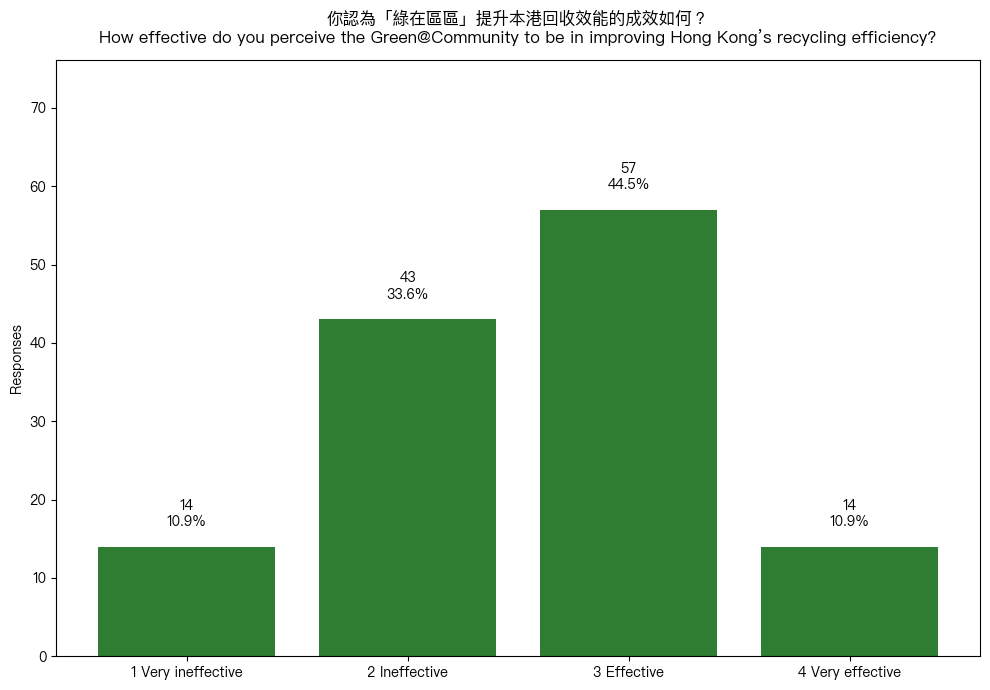

In [1]:
# ---------- install deps if missing ----------
import importlib, subprocess, sys
def _ensure(pkg, mod=None):
    try:
        importlib.import_module(mod or pkg)
    except ImportError:
        subprocess.check_call([sys.executable, "-m", "pip", "install", pkg])
_ensure("pandas"); _ensure("openpyxl"); _ensure("matplotlib")

# ---------- imports ----------
import re
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from pathlib import Path

# ---------- load data ----------
data_path = Path("../GCAP3226 G@C Survey Responses_cleaned data.xlsx")
df = pd.read_excel(data_path, engine="openpyxl")

# ---------- find the column (CN/EN; robust to spacing & variants) ----------
patterns = [
    r"how\s+effective.*green@community.*(improv(e|ing)\s+(hk|hong\s*kong)[’']?s?\s*recycling\s*efficiency|recycling\s*efficiency)",
    r"你認為.*綠在區區.*提升.*本港.*回收效能.*成效.*如何",
]
def find_col(columns):
    cols = [(c, re.sub(r"\s+", " ", str(c)).strip()) for c in columns]
    for c, norm in cols:
        if any(re.search(p, norm, flags=re.IGNORECASE) for p in patterns):
            return c
    for c, norm in cols:  # heuristic fallback
        if re.search(r"green@community", norm, flags=re.IGNORECASE) and re.search(r"effective|成效|效能", norm, flags=re.IGNORECASE):
            return c
    return None

col = find_col(df.columns)
if col is None:
    raise RuntimeError("Could not find the survey column for the recycling-efficiency effectiveness question.")

# ---------- map responses to Likert 1–4 and final labels ----------
series = df[col].dropna()

text_to_num = {
    "very ineffective": 1, "非常無效": 1, "極不有效": 1, "1": 1, 1: 1,
    "ineffective": 2, "無效": 2, "較無效": 2, "2": 2, 2: 2,
    "effective": 3, "有效": 3, "較有效": 3, "3": 3, 3: 3,
    "very effective": 4, "非常有效": 4, "極有效": 4, "4": 4, 4: 4,
}
def to_num(v):
    s = str(v).strip().lower()
    return text_to_num.get(v, text_to_num.get(s))

nums = series.map(to_num).dropna().astype(int)

label_map = {
    1: "1 Very ineffective",
    2: "2 Ineffective",
    3: "3 Effective",
    4: "4 Very effective",
}
order = [1, 2, 3, 4]
labels = [label_map[i] for i in order]
counts = nums.value_counts().reindex(order, fill_value=0)
total = int(counts.sum())
pct = (counts / total * 100).round(1) if total > 0 else counts.astype(float)

# ---------- fonts (Chinese-capable if available) ----------
for font_name in ["Noto Sans CJK TC", "PingFang TC", "PingFang HK", "Microsoft JhengHei", "SimHei"]:
    if any(font_name in f.name for f in matplotlib.font_manager.fontManager.ttflist):
        plt.rcParams["font.family"] = font_name
        break
plt.rcParams["axes.unicode_minus"] = False

# ---------- plot: vertical bar chart (green) with labels ABOVE bars ----------
fig, ax = plt.subplots(figsize=(10, 7), facecolor="white")
ax.set_facecolor("white")

bar_color = "#2e7d32"  # green
bars = ax.bar(labels, counts.values, color=bar_color)

# pad headroom so labels don't clip
ymax = max(1, counts.max())
ax.set_ylim(0, ymax * 1.30 + 2)

for rect, v, p in zip(bars, counts.values, pct.values):
    ax.text(
        rect.get_x() + rect.get_width()/2,
        rect.get_height() + ymax * 0.04,
        f"{int(v)}\n{p:.1f}%",
        ha="center", va="bottom", fontsize=10
    )

ax.set_ylabel("Responses")
title_cn = "你認為「綠在區區」提升本港回收效能的成效如何？"
title_en = "How effective do you perceive the Green@Community to be in improving Hong Kong’s recycling efficiency?"
ax.set_title(title_cn + "\n" + title_en, pad=12)

plt.tight_layout()
plt.show()
